In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random_deletion

### Загрузим данные

In [9]:
creditg = pd.read_csv("dataset/credit-g.csv", header=True)
krkp = pd.read_csv("dataset/kr-vs-kp.csv", header=True)
segment = pd.read_csv("dataset/segment.csv", header=True)

#### KRKP

In [10]:
krkp.columns = ["col" + str(i) for i in range(1, 38)]

In [11]:
for i in range(1, 38):
    print(np.unique(krkp["col" + str(i)]))

['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['g' 'l']
['f' 't']
['b' 'n' 'w']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['n' 't']
['nowin' 'won']


In [12]:
from sklearn.preprocessing import LabelEncoder

for i in range(1, 38):
    krkp["col" + str(i)] = LabelEncoder().fit_transform(krkp["col" + str(i)])

In [13]:
for i in range(1, 38):
    print(np.unique(krkp["col" + str(i)]))

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1 2]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [14]:
krkp_y = krkp["col37"]
krkp.drop("col37", axis=1, inplace=True)

In [15]:
krkp = np.array(krkp, dtype='float')
krkp_y = np.array(krkp_y)

In [16]:
krkp

array([[ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  1.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.]])

##### 5 % пропущенных значений во всех объектах и всех признаках.

In [17]:
krkp_del = random_deletion.make_missing_value(krkp, del_fraction=0.05)

In [18]:
krkp_del

array([[  0.,   0.,   0., ...,   1.,   1.,   0.],
       [  0.,   0.,   0., ...,   1.,   1.,   0.],
       [  0.,   0.,   0., ...,   1.,   1.,   0.],
       ..., 
       [  1.,   0.,   0., ...,  nan,   0.,   0.],
       [  1.,   0.,   1., ...,   0.,   0.,   0.],
       [  1.,   0.,   1., ...,   0.,   0.,   0.]])

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, cross_val_score

In [20]:
cv = KFold(krkp_y.shape[0], n_folds=10, shuffle=True, random_state=798)
clf = RandomForestClassifier(n_jobs=-1, random_state=567)

##### 1. Без пропущенных значений.

In [21]:
print(np.mean(cross_val_score(clf, krkp, krkp_y, scoring='accuracy', cv=cv)))

0.989672805643


##### 2. Игнорируем объекты с пропущенными значениями.

In [22]:
mask = np.sum(krkp_del != krkp_del, axis=1) == 0
krkp_del_ignore = krkp_del[mask]
krkp_y_ignore = krkp_y[mask]
print('count =', mask.sum())

count = 517


In [23]:
print(np.mean(cross_val_score(clf, krkp_del_ignore, krkp_y_ignore, scoring='accuracy', cv=10)))

0.91466214178


##### 3. Заполнение специальным значение (-1).

In [24]:
mask = krkp_del != krkp_del
krkp_del_special = np.array(krkp_del)
krkp_del_special[mask] = -1

In [25]:
print(np.mean(cross_val_score(clf, krkp_del_special, krkp_y, scoring='accuracy', cv=cv)))

0.955881661442


##### 4. Заполнение самым частым значением.

In [26]:
from scipy.stats.mstats import mode

krkp_del_common = np.array(krkp_del)
for i in range(krkp_del_common.shape[1]):
    mask = krkp_del_common[:, i] != krkp_del_common[:, i]
    krkp_del_common[mask, i] = mode(krkp_del_common[np.logical_not(mask), i])[0][0]

In [27]:
print(np.mean(cross_val_score(clf, krkp_del_common, krkp_y, scoring='accuracy', cv=cv)))

0.954627742947


##### 5. Заполнение с помощью SVD.

In [62]:
import data_recovery
from importlib import reload
reload(data_recovery)

krkp_del_svd = data_recovery.svd_imputer(krkp_del, rank=20)

In [63]:
print(np.mean(cross_val_score(clf, krkp_del_svd, krkp_y, scoring='accuracy', cv=cv)))

0.965579937304


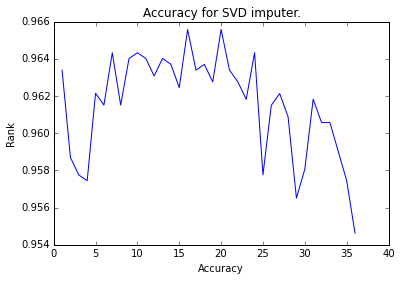

In [56]:
accuracy = []
for i in range(1, 37):
    krkp_del_svd = data_recovery.svd_imputer(krkp_del, rank=i)
    accuracy.append(np.mean(cross_val_score(clf, krkp_del_svd, krkp_y, scoring='accuracy', cv=cv)))

plt.plot(list(range(1, 37)), accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Rank")
plt.title("Accuracy for SVD imputer.")

##### 6. Заполнение с помощью kNN.

In [57]:
reload(data_recovery)

krkp_del_knn = data_recovery.knn_imputer(krkp_del, n_neighbors=5)

In [58]:
print(np.mean(cross_val_score(clf, krkp_del_knn, krkp_y, scoring='accuracy', cv=cv)))

0.958066222571


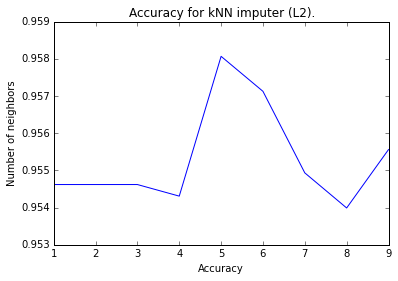

In [60]:
accuracy = []
for i in range(1, 10):
    krkp_del_knn = data_recovery.knn_imputer(krkp_del, n_neighbors=i)
    accuracy.append(np.mean(cross_val_score(clf, krkp_del_knn, krkp_y, scoring='accuracy', cv=cv)))

plt.plot(list(range(1, 10)), accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Number of neighbors")
plt.title("Accuracy for kNN imputer (L2).")

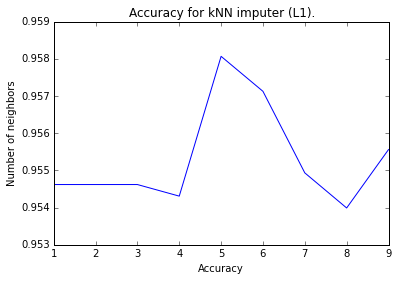

In [61]:
accuracy = []
for i in range(1, 10):
    krkp_del_knn = data_recovery.knn_imputer(krkp_del, n_neighbors=i, metric='l2')
    accuracy.append(np.mean(cross_val_score(clf, krkp_del_knn, krkp_y, scoring='accuracy', cv=cv)))

plt.plot(list(range(1, 10)), accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Number of neighbors")
plt.title("Accuracy for kNN imputer (L1).")